# Imports

In [1]:
from ase import Atoms

In [2]:
from ase.build import bulk

In [3]:
from ase.calculators.morse import MorsePotential

In [4]:
from pyiron_contrib.tinybase.ase import AseStaticTask, AseMDTask, AseMinimizeTask

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [5]:
from pyiron_contrib.tinybase.murn import MurnaghanTask

In [6]:
from pyiron_contrib.tinybase.executor import ProcessExecutor, BackgroundExecutor, Executor

In [7]:
import logging
logging.getLogger().setLevel(20)

# Simple ASE Static Calculation

In [39]:
a = AseStaticTask()

In [40]:
a.input.structure = bulk("Fe")

In [41]:
a.input.calculator = MorsePotential()

In [42]:
ret, output = a.execute(); ret, output

(ReturnStatus(Code.DONE, None),
 <pyiron_contrib.tinybase.container.EnergyOutput at 0x7f6c585e9f90>)

In [12]:
output.energy_pot

-0.00013307075712109978

# ASE MD

In [43]:
md = AseMDTask()

In [44]:
md.input.structure = bulk("Fe", a=1.2, cubic=True).repeat(3)
md.input.calculator = MorsePotential()

In [45]:
md.input.steps = 100
md.input.timestep = 3
md.input.temperature = 600
md.input.output_steps = 20

In [50]:
exe = ProcessExecutor(max_processes=4).submit([md])
exe.run()

In [51]:
exe.wait()

In [52]:
exe._run_machine._data

{'status': [ReturnStatus(Code.DONE, None)],
 'output': [<pyiron_contrib.tinybase.container.MDOutput at 0x7f6c584fb310>]}

In [53]:
exe._run_machine.state

<Code.FINISHED: 'finished'>

In [54]:
exe._run_time

10.619871525006602

In [55]:
exe._collect_time

0.00010890099656535313

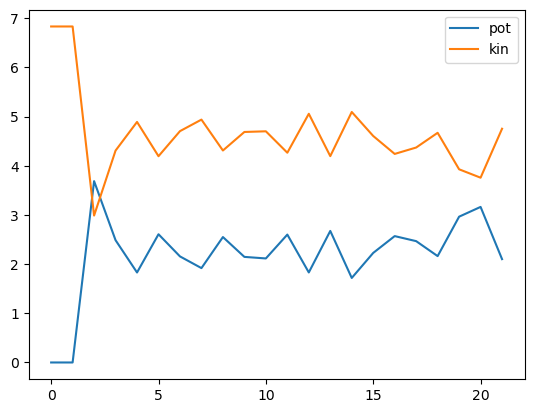

In [56]:
exe.output[0].plot_energies()

In [58]:
exe.output[0].animate_structures()

NGLWidget(max_frame=21)

# ASE Minimize

In [59]:
from pyiron_atomistics import ase_to_pyiron

In [60]:
mi = AseMinimizeTask()

In [61]:
dimer = Atoms(symbols=['Fe', 'Fe'], positions=[[0,0,0], [0,0, .75]], cell=[10,10,10])

In [62]:
mi.input.structure = dimer
mi.input.calculator = MorsePotential(rcut1=6,rcut2=10)

In [63]:
ase_to_pyiron(mi.input.structure).plot3d()

NGLWidget()

In [64]:
mi.input.max_steps = 100
mi.input.output_steps = 1
mi.input.ionic_force_tolerance = 1e-6

In [65]:
mi.input.gpmin()

In [66]:
exe = Executor().submit([mi])

In [67]:
exe.run()

       Step     Time          Energy         fmax
GPMin:    0 16:26:11       11.122159      187.2462
GPMin:    1 16:26:11       -0.278268        1.5338
GPMin:    2 16:26:11       -0.996055        0.8010
GPMin:    3 16:26:11       -0.000000        0.0000


In [68]:
exe.status

(ReturnStatus(Code.DONE, None),)

In [69]:
abs(exe.output[0].forces[-1]).max()

2.136147842601888e-07

In [70]:
exe._run_machine.state

<Code.FINISHED: 'finished'>

In [71]:
exe._run_time

0.07873644600476837

In [72]:
exe._collect_time

1.3546996342483908e-05

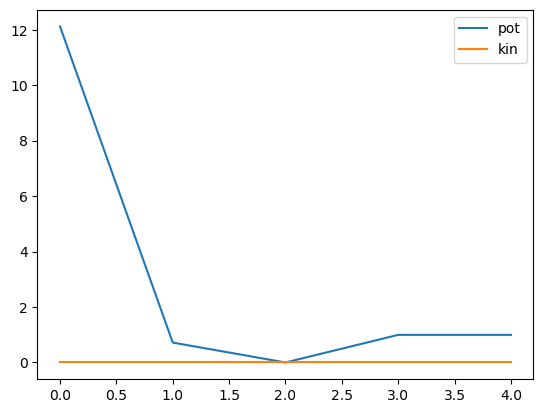

In [73]:
exe.output[0].plot_energies()

In [74]:
exe.output[0].pot_energies

[11.122158782511535,
 -0.2782678462106827,
 -0.9960554302957411,
 -3.560246436024868e-08,
 -3.560246436024868e-08]

In [75]:
exe.output[0].animate_structures()

NGLWidget(max_frame=4)

# Murnaghan

## Basic

In [8]:
m = MurnaghanTask()

In [9]:
m.input.task = AseStaticTask()
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [10]:
m.input.task.input

In [11]:
m.input.set_strain_range(.5, 50)

In [12]:
m.input.strains

array([0.79370053, 0.8043555 , 0.81473542, 0.82485739, 0.83473686,
       0.84438786, 0.85382314, 0.86305437, 0.87209225, 0.88094658,
       0.88962642, 0.89814011, 0.90649538, 0.9146994 , 0.92275884,
       0.93067991, 0.93846839, 0.94612969, 0.95366889, 0.96109074,
       0.96839969, 0.97559996, 0.98269548, 0.98968999, 0.996587  ,
       1.00338986, 1.01010169, 1.0167255 , 1.02326411, 1.0297202 ,
       1.03609634, 1.04239496, 1.04861836, 1.05476875, 1.06084824,
       1.06685884, 1.07280247, 1.07868096, 1.08449606, 1.09024946,
       1.09594278, 1.10157754, 1.10715524, 1.11267731, 1.1181451 ,
       1.12355993, 1.12892306, 1.13423572, 1.13949907, 1.14471424])

In [13]:
m.input.check_ready()

True

In [23]:
_, output = m.execute()

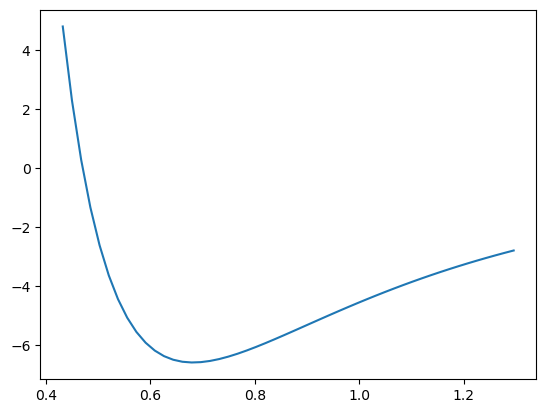

In [25]:
output.plot()

In [26]:
output.equilibrium_volume

0.6788586373205143

In [27]:
output.get_structure().get_volume()

0.6788586373205143

In [28]:
output.get_structure()

Atoms(symbols='Fe', pbc=True, cell=[[-0.5536557129291797, 0.5536557129291797, 0.5536557129291797], [0.5536557129291797, -0.5536557129291797, 0.5536557129291797], [0.5536557129291797, 0.5536557129291797, -0.5536557129291797]])

## Again but execute children as background processes, but keep the task itself blocking

In [8]:
m = MurnaghanTask()

In [9]:
m.input.task = AseStaticTask()
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [10]:
m.input.task.input

In [11]:
m.input.set_strain_range(.6, 1000)

In [15]:
ret, output = ProcessExecutor(max_processes=4).run(m)

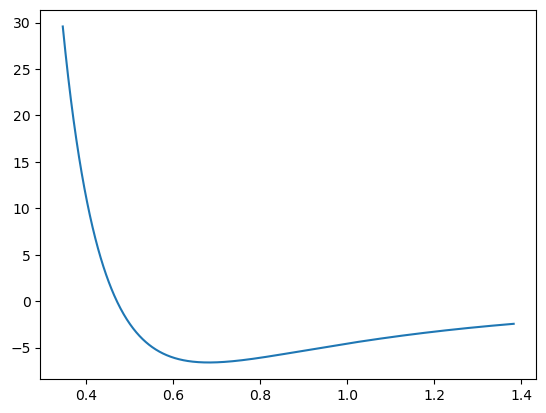

In [16]:
output.plot()

In [17]:
output.get_structure().get_volume()

0.6818586500998999

In [18]:
output.equilibrium_volume

0.6818586500999

## Again but execute everything in the background.

In [19]:
assert False, "broken in the TaskGenerator formalism"

AssertionError: broken in the TaskGenerator formalism

In [ ]:
m = MurnaghanTask()

In [ ]:
m.input.task = AseStaticTask()
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [ ]:
m.input.task.input

In [ ]:
m.input.set_strain_range(.5, 100)

Use the threading backend just to show off.

In [ ]:
from pyiron_contrib.tinybase.executor import BackgroundExecutor

m.input.child_executor = BackgroundExecutor

In [ ]:
exe = m.run(how='background')

In [ ]:
exe.wait()

In [ ]:
exe._run_machine.state

In [ ]:
exe._run_time

In [ ]:
exe._collect_time

In [ ]:
exe.output[0].plot()

# Combine Minimize and Murnaghan

In [20]:
m = MurnaghanTask()

In [21]:
m.input.task = AseMinimizeTask()
m.input.task.input.calculator = MorsePotential()
m.input.task.input.max_steps = 100
m.input.task.input.output_steps = 10
m.input.task.input.ionic_force_tolerance = 1e-6
m.input.task.input.lbfgs()

m.input.structure = bulk("Fe", a=1.2)

In [22]:
m.input.set_strain_range(.5, 500)

In [23]:
ret, output = ProcessExecutor(max_processes=8).run(m)

       Step     Time          Energy         fmax
       Step     Time          Energy         fmax
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        4.251945        0.0000
LBFGS:    0 17:04:52        3.244546        0.0000
LBFGS:    0 17:04:52        4.517693        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        3.488292        0.0000
       Step     Time          Energy         fmax
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        3.006013        0.0000
LBFGS:    0 17:04:52        4.789242        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        3.737364        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        3.991875        0.0000
       Step     Time          Energy         fmax
       Step     Time          Energy         fmax
LBFGS:    0 17:04:52        1.473327        0.0000
       Step     Time          Energy     

In [24]:
ret

ReturnStatus(Code.DONE, None)

In [25]:
output.energies[:10]

array([4.78924238, 4.51769267, 4.25194477, 3.99187529, 3.7373637 ,
       3.48829227, 3.244546  , 3.00601254, 2.77258214, 2.54414756])

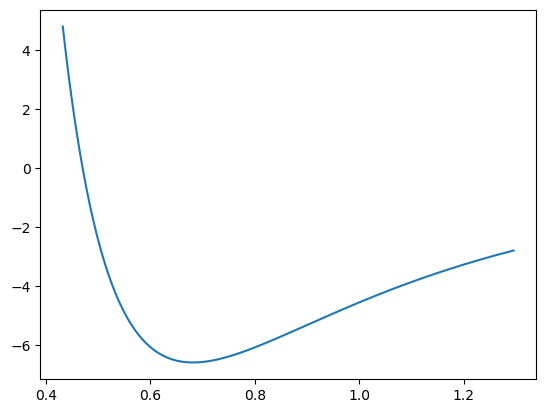

In [26]:
output.plot()